### Fetch data directory path

In [12]:
import os
from dotenv import load_dotenv

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']
result_dir_path = os.environ['RESULT_DIR_PATH']

### Import required modules

In [13]:
import h5py
import numpy as np
from matplotlib import pyplot as plt, gridspec

### Utility functions

In [14]:
def show_kspace_slice(kspace_path, slice_idx=0, coil_idxs=[0, 5, 10], cmap='gray'):
    # convert kspace slice to real image
    hf = h5py.File(kspace_path)
    kspace_slice = hf['kspace'][slice_idx]
    kspace_slice = np.log(np.abs(kspace_slice) + 1e-9)
    
    kspace_title = kspace_path.split('/')[-1]
    
    plt.figure()
    plt.suptitle(f'{kspace_title} - slice {slice_idx}')
    for i, coil_idx in enumerate(coil_idxs):
        ax = plt.subplot(1, len(coil_idxs), i + 1)
        plt.title(f'coil {coil_idx}')
        ax.imshow(kspace_slice[coil_idx], cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [15]:
def show_image_slice(img_path, slice_idx=0, cmap='gray'):
    img_keys = ['image_grappa', 'image_input', 'image_label']
    img_title = img_path.split('/')[-1]
    
    hf = h5py.File(img_path)
    plt.figure()
    plt.suptitle(f'{img_title} - slice {slice_idx}')
    for j, key in enumerate(img_keys):
        ax = plt.subplot(1, len(img_keys), j + 1)
        img_slice = hf[key][slice_idx]
        plt.title(key)
        ax.imshow(img_slice, cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [16]:
def get_masked_kspace_with_1d_mask(kspace, mask):
    """ 아직 미완성~~ """
    mask = np.tile(mask, (mask.shape[0], 1))
    raise NotImplementedError

In [17]:
def show_image_slices(img_path, model_name: str = "", is_recon = True, slice_idxs=[0], cmap='gray'):
    img_title = img_path.split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(slice_idxs))
    
    fig_img.suptitle(f'[{model_name}] {img_title}')
    for i, slice_idx in enumerate(slice_idxs):
        with h5py.File(img_path, 'r') as hf:
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, i])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'slice {slice_idx}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [18]:
def compare_image_slice(img_paths=None, model_names=None, slice_idx=0, cmap='gray'):
    if img_paths is None:
        img_paths = []
    if len(img_paths) < 1:
        return
    
    img_title = img_paths[0].split('/')[-1]
    fig_img = plt.figure(figsize=(16, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=len(img_paths))
    
    fig_img.suptitle(f'{img_title}')
    for idx, path in enumerate(img_paths):
        with h5py.File(path, 'r') as hf:
            is_recon = path.split('/')[-2] != 'image'
            img_slice = hf['reconstruction' if is_recon else 'image_label'][slice_idx]
            ax = fig_img.add_subplot(gs[0, idx])
            ax.imshow(img_slice, cmap=cmap)
            ax.title.set_text(f'{model_names[idx]}')
            ax.axis('off')  # Remove axes for a cleaner look
    
    fig_img.tight_layout()
    plt.show()
    plt.close(fig_img)

In [19]:
def is_equispaced_mask(mask, acc):
    prev_one_idx = -1
    cnt_not_equispaced = 0
    for idx, val in enumerate(mask):
        if val > 0:
            if (idx - prev_one_idx != acc
            and idx - prev_one_idx != 1
            and prev_one_idx >= 0):
                cnt_not_equispaced += 1
            prev_one_idx = idx
    return cnt_not_equispaced <= 2

In [20]:
def get_center_fractions(mask):
    prev_one_idx = -1
    center = 1
    for idx, val in enumerate(mask):
        if val > 0:
            if prev_one_idx > 0 and idx - prev_one_idx == 1:
                center += 1
            prev_one_idx = idx
    return center / len(mask)

### Data structure

**Image data (train/val)**

In [21]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


In [22]:
img['image_label'][0].shape

(384, 384)

In [23]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
recon_path = f'./result_large_aug2/test_Varnet/reconstructions_train/brain_acc4_1.h5'
img = h5py.File(img_path)
recon = h5py.File(recon_path)
print(img.keys())
print(recon.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>
<KeysViewHDF5 ['reconstruction']>


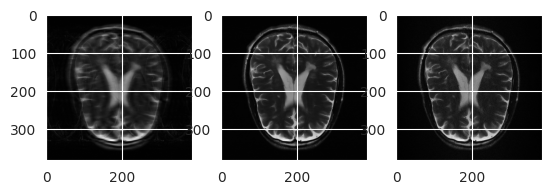

In [24]:
plt.subplot(1, 3, 1)
plt.imshow(img['image_input'][0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(recon['reconstruction'][0], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img['image_grappa'][0], cmap='gray')

In [25]:
img_concat = np.stack([img['image_input'][0], recon['reconstruction'][0], img['image_grappa'][0]])
img_concat = np.moveaxis(img_concat, 0, -1)
print(img_concat[..., 2])

[[1.01078031e-05 1.04279006e-05 1.11048266e-05 ... 7.75211629e-06
  9.28757800e-06 1.46979110e-05]
 [1.26147979e-05 1.25873466e-05 9.41377584e-06 ... 8.44843089e-06
  9.12935229e-06 1.25217530e-05]
 [9.30123224e-06 7.87839508e-06 9.94181937e-06 ... 1.15047105e-05
  9.40553582e-06 9.37434561e-06]
 ...
 [9.01505155e-06 1.04744477e-05 1.15646626e-05 ... 9.01581916e-06
  1.30521403e-05 1.03820103e-05]
 [6.38130859e-06 8.21080721e-06 7.71384202e-06 ... 1.02573758e-05
  7.84918393e-06 8.97190785e-06]
 [1.06005291e-05 8.21676804e-06 8.29710098e-06 ... 9.15091368e-06
  6.44879992e-06 7.37660866e-06]]


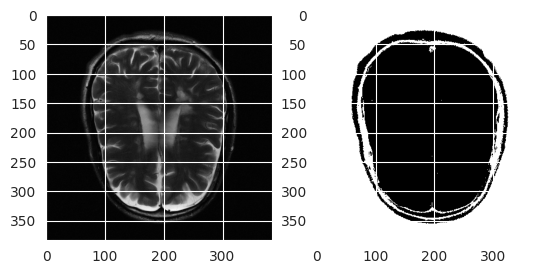

In [26]:
img_path = f'{data_dir_path}/train/image/brain_acc4_1.h5'
img = h5py.File(img_path)
target = img['image_label'][1]
mask = np.zeros(target.shape)
mask[target <= 5e-5] = 1
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

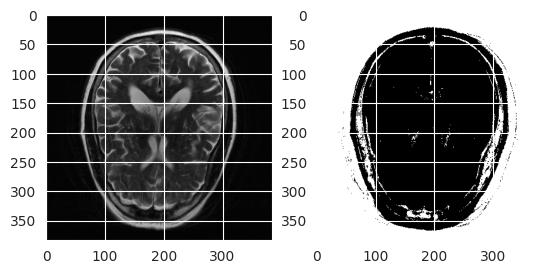

In [27]:
img_path = f'{data_dir_path}/leaderboard/acc5/image/brain_test5.h5'
img = h5py.File(img_path)
target = img['image_label'][1]
mask = np.zeros(target.shape)
mask[target <= 5e-5] = 1
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')

(16, 384, 384)


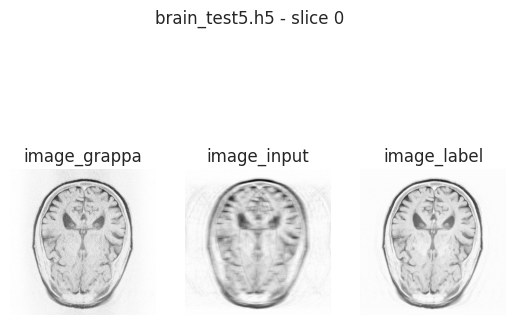

In [28]:
print(img['image_input'].shape)
show_image_slice(img_path, cmap='gray_r')

**Kspace data (train/val)**

In [29]:
import torch
from pygrappa import grappa
from fastmri import ifft2c, rss_complex

In [30]:
def complex_to_float(complex_tensor):
    return torch.stack((complex_tensor.real, complex_tensor.imag), dim=-1)

def float_to_complex(float_tensor):
    real_part = float_tensor[..., 0]
    imag_part = float_tensor[..., 1]
    complex_tensor = torch.complex(real_part, imag_part)
    return complex_tensor

In [31]:
kspace_path = f'{data_dir_path}/train/kspace/brain_acc4_1.h5'
kspace_data = h5py.File(kspace_path)

In [32]:
kspace = kspace_data['kspace'][0]
mask = kspace_data['mask']

kspace = torch.from_numpy(kspace)
mask = torch.from_numpy(np.array(mask))

kspace = torch.stack((kspace.real, kspace.imag), dim=-1)
mask = mask.reshape(1, 1, kspace.shape[-2], 1).float().byte()

In [33]:
masked_kspace = kspace * mask

In [34]:
masked_kspace = float_to_complex(masked_kspace)
kspace = float_to_complex(kspace)

In [35]:
kspace.shape

torch.Size([16, 768, 396])

In [36]:
np.moveaxis(np.array(kspace), 0, -1).shape

(768, 396, 16)

In [37]:
res = grappa(np.array(masked_kspace), np.array(kspace), coil_axis=-3)

In [38]:
type(res)

numpy.ndarray

In [39]:
image = ifft2c(complex_to_float(torch.from_numpy(res)))

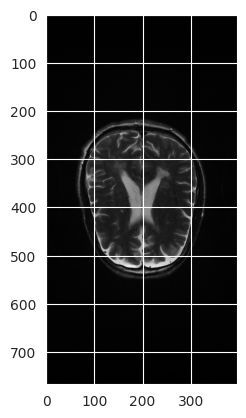

In [40]:
plt.imshow(rss_complex(image), cmap='gray')

In [41]:
print(kspace['kspace'][0][0][0][0].imag)

IndexError: too many indices for tensor of dimension 3

In [42]:
x = np.zeros((3, 4, 5))
np.moveaxis(x, 0, -1).shape

(4, 5, 3)

In [43]:
cnt_total_mask = 118
cnt_equispaced_mask = 0
acc = 4
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/train/kspace/brain_acc{acc}_{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=acc)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

# of equispaced masks: 118 / 118


(396,)
(16, 16, 768, 396)


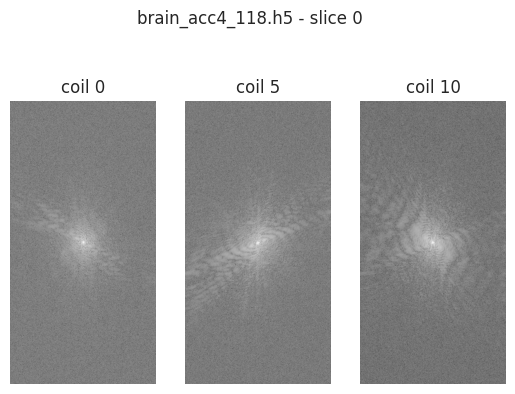

In [44]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)
show_kspace_slice(kspace_path)

In [45]:
kspace_path = f'{data_dir_path}/train/kspace/brain_acc8_111.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


(396,)
(16, 16, 768, 396)


IndexError: index 16 is out of bounds for axis 0 with size 16

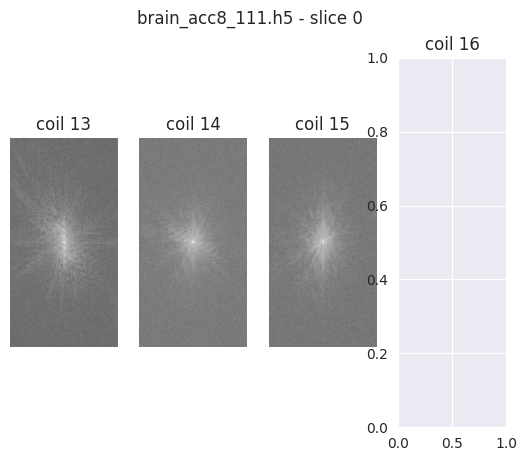

In [46]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)
show_kspace_slice(kspace_path, coil_idxs=[13,14,15,16])

**Image data (leaderboard)**

In [47]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test2.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


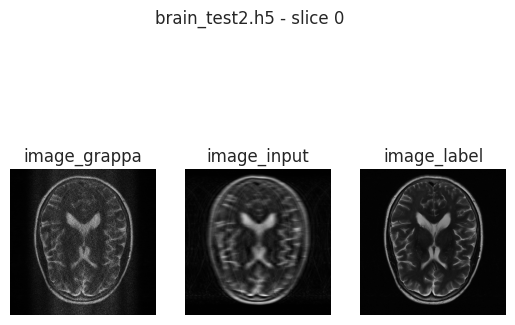

In [48]:
show_image_slice(img_path)

**Kspace data (leaderboard)**

In [49]:
kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test1.h5'
kspace = h5py.File(kspace_path)
print(kspace.keys())

<KeysViewHDF5 ['kspace', 'mask']>


In [50]:
cnt_total_mask = 58
cnt_equispaced_mask = 0
for i in range(1, cnt_total_mask + 1):
    kspace_path = f'{data_dir_path}/leaderboard/acc5/kspace/brain_test{i}.h5'
    kspace = h5py.File(kspace_path)
    cnt_equispaced_mask += is_equispaced_mask(kspace['mask'][()], acc=5)

print(f'# of equispaced masks: {cnt_equispaced_mask} / {cnt_total_mask}')

# of equispaced masks: 58 / 58


In [51]:
print(kspace['mask'].shape)
print(kspace['kspace'].shape)

(396,)
(16, 16, 768, 396)


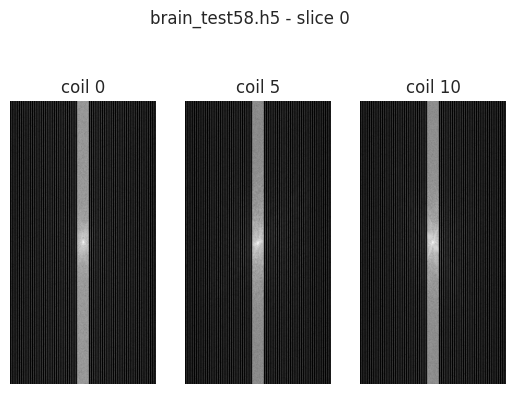

In [52]:
show_kspace_slice(kspace_path)

**정리**
- Image: slices x 384 x 384
- Kspace: slices x coils x 768 x 392/396
- train/val/leaderboard 모두 equispaced mask로 undersampled됨 (일부 mask에 **offset** 존재)
    - center fraction: 0.08~0.084
    - `fastmri.data.subsample.EquispacedMaskFunc()`으로 만들 수 있음

## Mask

In [53]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test1.h5'
img = h5py.File(img_path)
img_label = img['image_label']

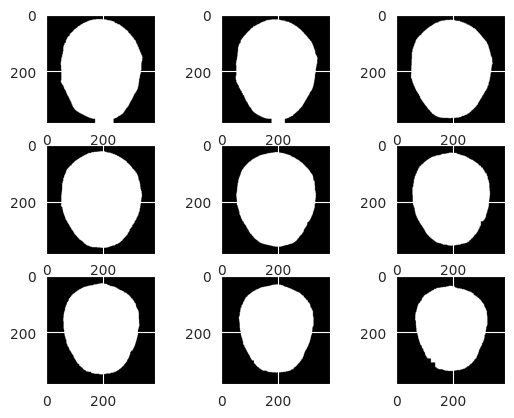

In [54]:
import cv2

for i in range(9):
    target = img['image_label'][i]
    mask = np.zeros(target.shape)
    mask[target > 5e-5] = 1
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    mask = cv2.dilate(mask, kernel, iterations=15)
    mask = cv2.erode(mask, kernel, iterations=14)
    plt.subplot(3, 3, i+1)
    plt.imshow(mask, cmap='gray')

In [55]:
img_path = f'{data_dir_path}/train/image/brain_acc4_2.h5'
img = h5py.File(img_path)
img_label = img['image_label']
print(img_label.shape)

(16, 384, 384)


(-0.5, 383.5, 383.5, -0.5)

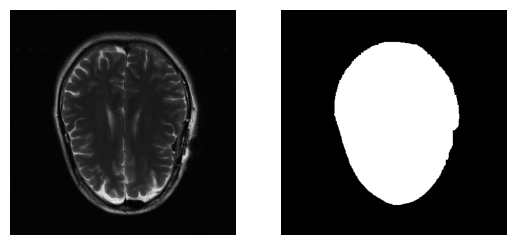

In [66]:
target = img_label[5]

mask = np.zeros(target.shape)
plt.subplot(1, 2, 1)
plt.imshow(target, cmap='gray')
plt.axis('off')

mask[target > 5e-5] = 1
kernel = np.ones((3, 3), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
mask = cv2.dilate(mask, kernel, iterations=15)
mask = cv2.erode(mask, kernel, iterations=30)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')

(-0.5, 383.5, 383.5, -0.5)

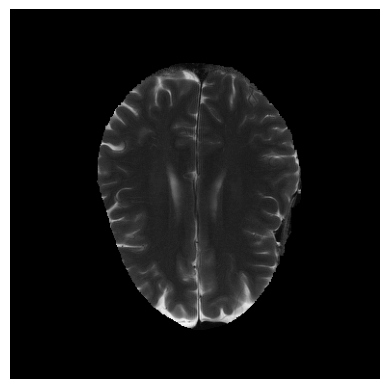

In [68]:
plt.imshow(mask * target, cmap='gray')
plt.axis('off')

## Data Distribution

In [452]:
import glob
def get_mean_list(img_dir):
    img_mean = []
    for img_path in glob.glob(img_dir):
        img = h5py.File(img_path)
        img_mean.append(np.mean(img['image_label']))
    return np.array(img_mean)

def get_var_list(img_dir):
    img_var = []
    for img_path in glob.glob(img_dir):
        img = h5py.File(img_path)
        img_var.append(np.var(img['image_label']))
    return np.array(img_var)

In [348]:
img['image_label'][0]

array([[1.8735205e-05, 2.4931751e-05, 1.8362052e-05, ..., 2.2193075e-05,
        2.5709020e-05, 1.8413226e-05],
       [1.8363608e-05, 2.4478601e-05, 1.6693541e-05, ..., 2.1525066e-05,
        2.4440973e-05, 2.1904505e-05],
       [2.3107041e-05, 2.4893658e-05, 2.1454260e-05, ..., 2.3427530e-05,
        2.2225968e-05, 2.0202155e-05],
       ...,
       [1.6855091e-05, 2.1853279e-05, 2.0993863e-05, ..., 2.5016538e-05,
        2.0799787e-05, 1.6054066e-05],
       [1.9526449e-05, 2.0974672e-05, 2.0006661e-05, ..., 1.7876480e-05,
        2.4555662e-05, 1.4184588e-05],
       [1.5793146e-05, 1.8276818e-05, 1.8467237e-05, ..., 1.9624003e-05,
        1.6134409e-05, 2.4147414e-05]], dtype=float32)

In [274]:
train_img_dir = f'{data_dir_path}/train/image/*'
val_img_dir = f'{data_dir_path}/val/image/*'
leaderboard_img_dir = f'{data_dir_path}/leaderboard/*/image/*'

train_img_mean = get_mean_list(train_img_dir)
val_img_mean = get_mean_list(val_img_dir)
leaderboard_img_mean = get_mean_list(leaderboard_img_dir)

train_img_var = get_var_list(train_img_dir)
val_img_var = get_var_list(val_img_dir)
leaderboard_img_var = get_var_list(leaderboard_img_dir)

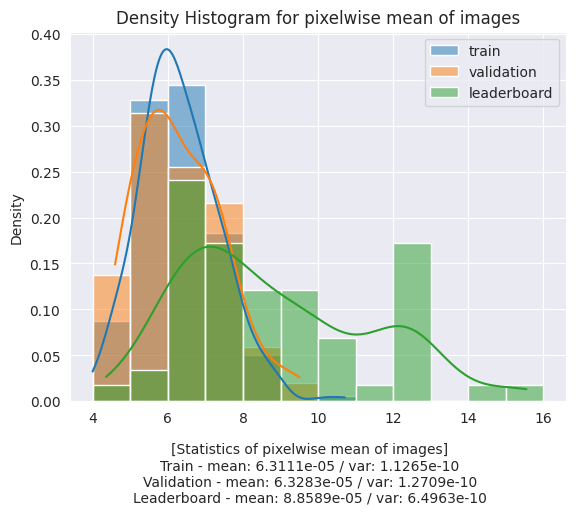

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=train_img_mean * 1e5, label="train", stat="density", binwidth=1, binrange=(4, 16),  kde=True)
sns.histplot(data=val_img_mean * 1e5, label="validation", stat="density", binwidth=1, binrange=(4, 16), kde=True)
sns.histplot(data=leaderboard_img_mean * 1e5, label="leaderboard", stat="density", binwidth=1, binrange=(4, 16), kde=True)

plt.title("Density Histogram for pixelwise mean of images")
caption = f"""[Statistics of pixelwise mean of images]
Train - mean: {np.mean(train_img_mean):.4e} / var: {np.var(train_img_mean):.4e}
Validation - mean: {np.mean(val_img_mean):.4e} / var: {np.var(val_img_mean):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_mean):.4e} / var: {np.var(leaderboard_img_mean):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

In [433]:
print(np.mean(leaderboard_img_mean) / np.mean(train_img_mean))
print(np.var(leaderboard_img_mean[leaderboard_img_mean < 14 * 1e-5]) / np.var(train_img_mean))
print(np.var(leaderboard_img_mean) / np.var(train_img_mean))

1.4037081
4.6406293
5.766953


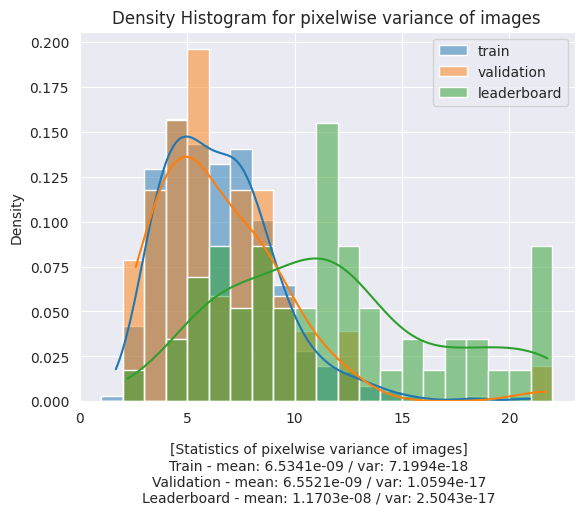

In [426]:
sns.histplot(data=train_img_var * 1e9, label="train", stat="density", binwidth=1, binrange=(1, 22), kde=True)
sns.histplot(data=val_img_var * 1e9, label="validation", stat="density", binwidth=1, binrange=(1, 22), kde=True)
sns.histplot(data=leaderboard_img_var * 1e9, label="leaderboard", stat="density", binwidth=1, binrange=(1, 22), kde=True)

plt.title("Density Histogram for pixelwise variance of images")
caption = f"""[Statistics of pixelwise variance of images]
Train - mean: {np.mean(train_img_var):.4e} / var: {np.var(train_img_var):.4e}
Validation - mean: {np.mean(val_img_var):.4e} / var: {np.var(val_img_var):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_var):.4e} / var: {np.var(leaderboard_img_var):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

In [442]:
print(np.mean(leaderboard_img_var) / np.mean(train_img_var))
print(np.var(leaderboard_img_var) / np.var(train_img_var[train_img_var < 17 * 1e-9]))
print(np.var(leaderboard_img_var) / np.var(train_img_var))

1.7910918
4.0019135
3.478485


<Axes: xlabel='mean', ylabel='var'>

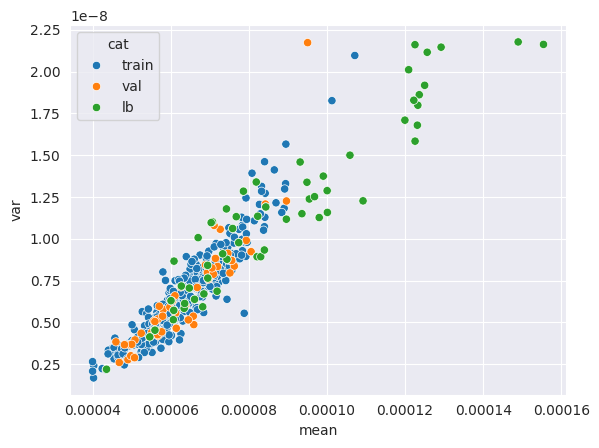

In [470]:
import pandas as pd

cat = np.array(['train'] * len(train_img_mean)
               + ['val'] * len(val_img_mean)
               + ['lb'] * len(leaderboard_img_mean))
df = pd.DataFrame({
    "mean": np.append(np.append(train_img_mean, val_img_mean), leaderboard_img_mean),
    "var": np.append(np.append(train_img_var, val_img_var), leaderboard_img_var),
    'cat': cat
})
# df = df[df['cat'].isin(['train', 'val'])]
sns.scatterplot(data=df, x="mean", y="var", hue="cat")

train/val dataset에 비해 leaderboard dataset의 평균/분산의 분포가 더 넓다

In [517]:
import torch
import glob
import random

def get_adjusted_statistic_list(img_dir, brightness_factor=1.4, bf_adjust=0.0, contrast_factor=1.0, cf_adjust=0.0):
    img_mean = []
    img_var = []
    for img_path in glob.glob(img_dir):
        img = h5py.File(img_path)
        tmp_mean = []
        tmp_var = []
        for im in img['image_label']:
            im = TF.to_tensor(im)
            bf = random.uniform(brightness_factor-bf_adjust, brightness_factor+bf_adjust)
            cf = random.uniform(contrast_factor-cf_adjust, contrast_factor+cf_adjust)
            adjusted_im = TF.adjust_brightness(im.unsqueeze(1),brightness_factor=bf).squeeze(1)
            adjusted_im = TF.adjust_contrast(adjusted_im.unsqueeze(1), contrast_factor=cf).squeeze(1)
            tmp_mean.append(torch.mean(adjusted_im).item())
            tmp_var.append(torch.var(adjusted_im).item())
        img_mean.append(np.mean(tmp_mean))
        img_var.append(np.mean(tmp_var))
    return np.array(img_mean), np.array(img_var)

In [564]:
adjusted_train_img_mean, adjusted_train_img_var = get_adjusted_statistic_list(train_img_dir, brightness_factor=1.4, bf_adjust=0.7, contrast_factor=0.9, cf_adjust=0.05)
adjusted_val_img_mean, adjusted_val_img_var = get_adjusted_statistic_list(val_img_dir, brightness_factor=1.4, bf_adjust=0.7, contrast_factor=0.9, cf_adjust=0.05)

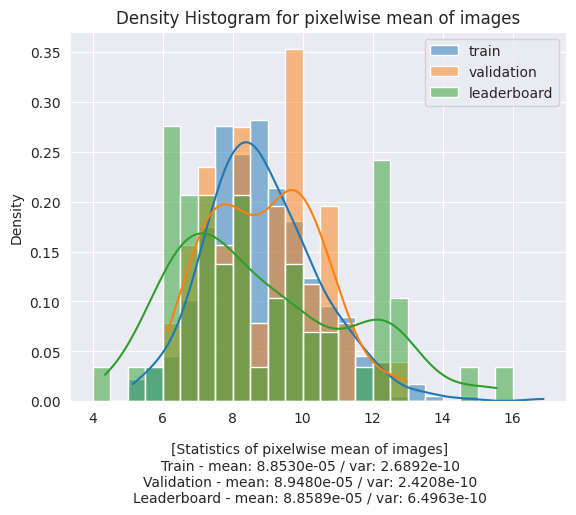

In [565]:
sns.histplot(data=adjusted_train_img_mean * 1e5, label="train", stat="density", binwidth=0.5, binrange=(4, 16),  kde=True)
sns.histplot(data=adjusted_val_img_mean * 1e5, label="validation", stat="density", binwidth=0.5, binrange=(4, 16), kde=True)
sns.histplot(data=leaderboard_img_mean * 1e5, label="leaderboard", stat="density", binwidth=0.5, binrange=(4, 16), kde=True)

plt.title("Density Histogram for pixelwise mean of images")
caption = f"""[Statistics of pixelwise mean of images]
Train - mean: {np.mean(adjusted_train_img_mean):.4e} / var: {np.var(adjusted_train_img_mean):.4e}
Validation - mean: {np.mean(adjusted_val_img_mean):.4e} / var: {np.var(adjusted_val_img_mean):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_mean):.4e} / var: {np.var(leaderboard_img_mean):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

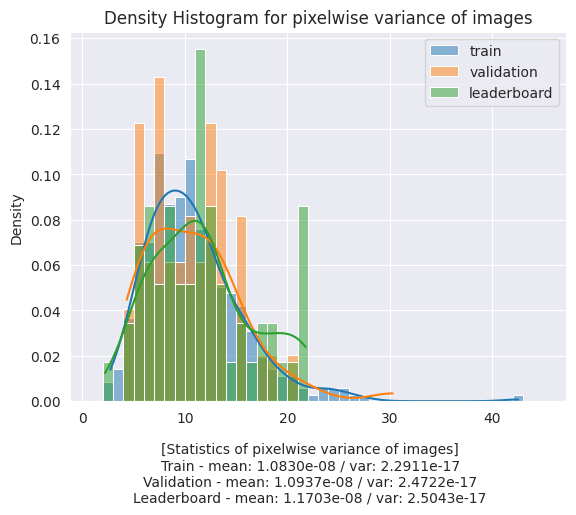

In [566]:
sns.histplot(data=adjusted_train_img_var * 1e9, label="train", stat="density", binwidth=1, binrange=(1, 45), kde=True)
sns.histplot(data=adjusted_val_img_var * 1e9, label="validation", stat="density", binwidth=1, binrange=(1, 22), kde=True)
sns.histplot(data=leaderboard_img_var * 1e9, label="leaderboard", stat="density", binwidth=1, binrange=(1, 22), kde=True)


plt.title("Density Histogram for pixelwise variance of images")
caption = f"""[Statistics of pixelwise variance of images]
Train - mean: {np.mean(adjusted_train_img_var):.4e} / var: {np.var(adjusted_train_img_var):.4e}
Validation - mean: {np.mean(adjusted_val_img_var):.4e} / var: {np.var(adjusted_val_img_var):.4e}
Leaderboard - mean: {np.mean(leaderboard_img_var):.4e} / var: {np.var(leaderboard_img_var):.4e}"""
plt.figtext(0.5, -0.1, caption, horizontalalignment="center")
plt.legend()

In [591]:
import torchvision.transforms.functional as TF
im = TF.to_tensor(img_label[0])
adjusted_im = TF.adjust_contrast(im.unsqueeze(1), 0.1).squeeze(1)

im_mean = torch.mean(im)
adjusted_im_mean = torch.mean(adjusted_im)

im_var = torch.var(im)
adjusted_im_var = torch.var(adjusted_im)

(-0.5, 383.5, 383.5, -0.5)

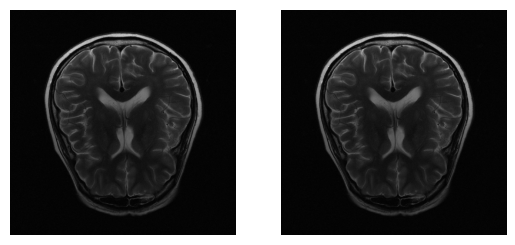

In [603]:
plt.subplot(1, 2, 1)
plt.imshow(im[0], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(adjusted_im[0], cmap='gray')
plt.axis('off')

<class 'numpy.ndarray'>


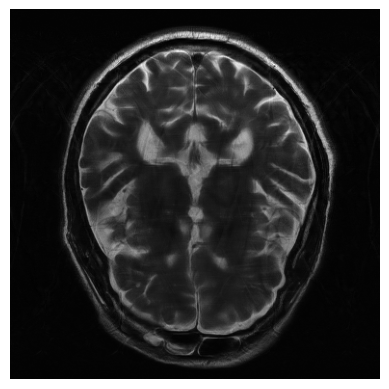

In [604]:
img_path = f'./result_accum16/test_Varnet/reconstructions_leaderboard/public/brain_test1.h5'
img = h5py.File(img_path, 'r')
plt.imshow(img['reconstruction'][0], cmap='gray')
plt.axis('off')
print(type(img['reconstruction'][0]))

In [638]:
img.keys()

<KeysViewHDF5 ['reconstruction']>

In [636]:
img_slice = img['reconstruction'][0]
max_pixel_intensity = np.max(img_slice)
img_slice /= max_pixel_intensity
sigma = 0.02

noised_img_slice = np.empty(img_slice.shape)
for i in range(img_slice.shape[0]):
    for j in range(img_slice.shape[1]):
        lx = max(0, i - 5)
        rx = min(img_slice.shape[0] - 1, i + 5)
        ly = max(0, j - 5)
        ry = min(img_slice.shape[1] - 1, j + 5)
        std = sigma * np.median(img_slice[lx:rx+1, ly:ry+1])
        noised_img_slice[i, j] = img_slice[i, j] + np.random.normal(0, std)

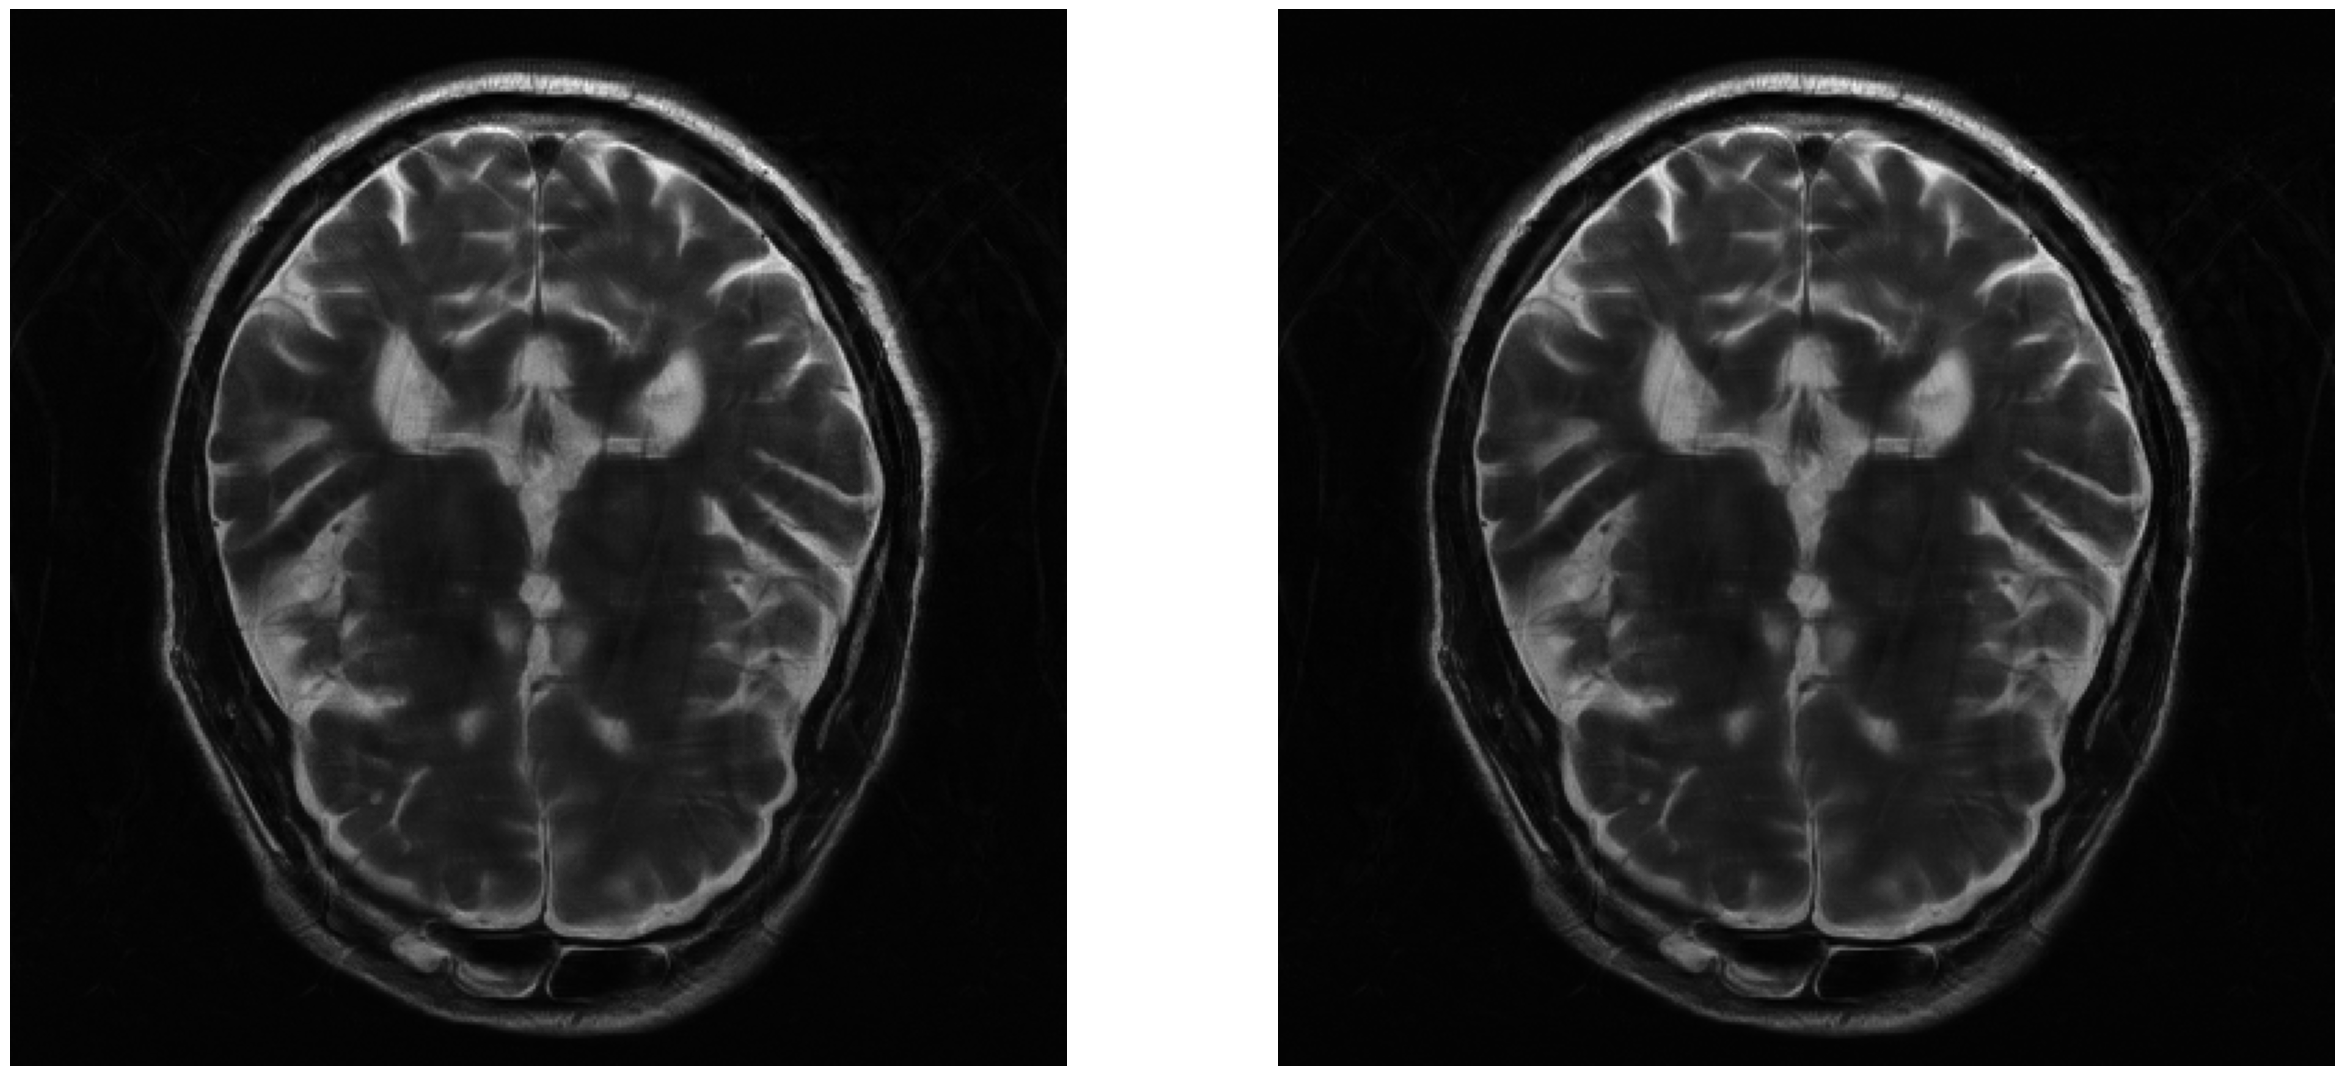

In [637]:
plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img_slice, cmap='gray')
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(noised_img_slice, cmap='gray')

## Distribution of number of slices

In [640]:
data_dir_path = os.environ['DATA_DIR_PATH']
train_img_dir = os.path.join(data_dir_path, 'train', 'image')
train_img_slices = []
for file in glob.glob(os.path.join(train_img_dir, '*.h5')):
    with h5py.File(file, 'r') as f:
        image = f['image_label']
        train_img_slices.append(image.shape[0])

In [649]:
val_img_dir = os.path.join(data_dir_path, 'val', 'image')
val_img_slices = []
for file in glob.glob(os.path.join(val_img_dir, '*.h5')):
    with h5py.File(file, 'r') as f:
        image = f['image_label']
        val_img_slices.append(image.shape[0])

In [650]:
np.unique(train_img_slices)

array([10, 12, 14, 16])

In [651]:
np.unique(val_img_slices)

array([14, 16])

In [690]:
lb_img_slices = []
acc_list = ['acc5']
for acc in acc_list:
    lb_img_dir = os.path.join(data_dir_path, 'leaderboard', acc, 'image')
    for file in glob.glob(os.path.join(lb_img_dir, '*.h5')):
        with h5py.File(file, 'r') as f:
            image = f['image_label']
            lb_img_slices.append(image.shape[0])

In [692]:
print(lb_img_slices)

[16, 16, 16, 16, 16, 16, 16, 16, 22, 22, 22, 16, 22, 22, 16, 20, 22, 22, 22, 22, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16]


In [691]:
np.unique(lb_img_slices)

array([14, 16, 20, 22])

In [684]:
def denoising(img_slice):
    maximum = np.max(img_slice)
    img_slice *= 255.0 / maximum
    img_slice = np.expand_dims(img_slice, axis=2).astype(np.uint8)
    ret = np.squeeze(cv2.fastNlMeansDenoising(img_slice, None, 5, 5, 21)).astype(np.float32)
    ret *= maximum / 255.0
    return ret

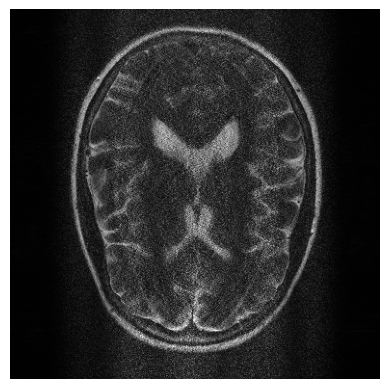

In [688]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test2.h5'
img = h5py.File(img_path)
img_slice = img['image_grappa'][0]
plt.axis('off')
plt.imshow(img_slice, cmap='gray')

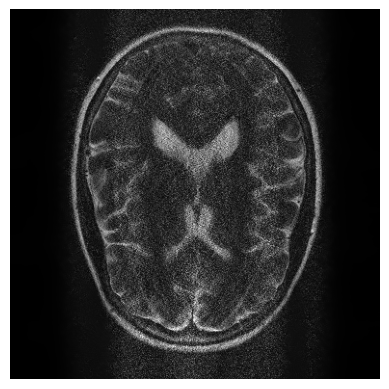

In [689]:
plt.axis('off')
plt.imshow(denoising(img_slice), cmap='gray')

## Image Augmentation

### Cutmix

In [247]:
from math import sqrt

rng = np.random.RandomState()

def _cutmix(im, alpha=0.4):
    """
    perform cutmix augmentation with batches of images
    :param im: input images to be augmented with shape [B, 4, H, W]
    :return output: augmented images with shape [B, 4, H, W]
    """
    B, C, H, W = im.shape
    lam = float(rng.beta(alpha, alpha))

    # Compute the bounding box for cut region
    r_x = torch.randint(W, size=(1,))
    r_y = torch.randint(H, size=(1,))

    r = 0.5 * sqrt(1.0 - lam)
    r_w_half = int(r * W)
    r_h_half = int(r * H)

    x1 = int(torch.clamp(r_x - r_w_half, min=0))
    y1 = int(torch.clamp(r_y - r_h_half, min=0))
    x2 = int(torch.clamp(r_x + r_w_half, max=W))
    y2 = int(torch.clamp(r_y + r_h_half, max=H))

    # shuffle images
    rolled = im.roll(1, 0)
    output = im.clone()
    output[..., y1:y2, x1:x2] = rolled[..., y1:y2, x1:x2]
    print("lambda:", lam)

    return output

In [248]:
def _mixup(im, alpha=0.4):
    """
    perform mixup augmentation with batches of images
    :param im: input images to be augmented with shape [B, 4, H, W]
    :return output: augmented images with shape [B, 4, H, W]
    """
    B, C, H, W = im.shape
    lam = float(rng.beta(alpha, alpha))

    # shuffle images
    rolled = im.roll(1, 0)
    output = im * lam + rolled * (1.0 - lam)
    print("lambda:", lam)

    return output

In [217]:
def augment(images, targets, aug_func, is_validation=False):
    """
    Generates augmented kspace and corresponding augmented target pair.
    kspace: torch tensor of shape [B, 3, H, W]
    target: torch tensor of shape [B, H, W]
    """
    im_batch = torch.cat([images, targets.unsqueeze(1)], dim=1)
    augmented_im_batch = aug_func(im_batch)
    augmented_images = augmented_im_batch[:, :-1, :, :]
    augmented_targets = augmented_im_batch[:, -1, :, :]

    return augmented_images, augmented_targets

In [219]:
img_path = f'{data_dir_path}/leaderboard/acc9/image/brain_test2.h5'
img = h5py.File(img_path)
print(img.keys())

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>


In [190]:
image_inputs = torch.stack([torch.stack([torch.from_numpy(i1), torch.from_numpy(i2)]) for i1, i2 in zip(img['image_input'], img['image_grappa'])])

In [191]:
image_labels = torch.stack([torch.from_numpy(im) for im in img['image_label']])

In [252]:
mixed_images, mixed_targets = augment(image_inputs, image_labels, _mixup)

lambda: 0.788056883870508


In [253]:
mixed_images, mixed_targets = augment(mixed_images, mixed_targets, _cutmix)

lambda: 0.2945112447025063


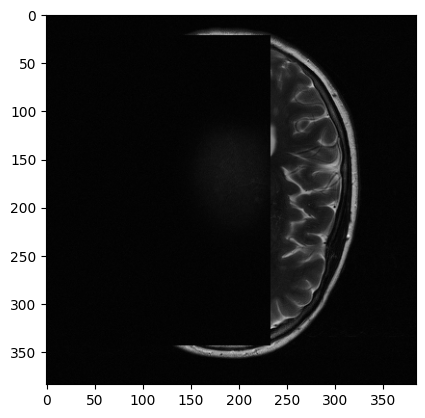

In [255]:
# plt.subplot(1, 2, 1)
# plt.imshow(mixed_images[0][0], cmap='gray')
# plt.subplot(1, 2, 2)
plt.imshow(mixed_targets[0], cmap='gray')

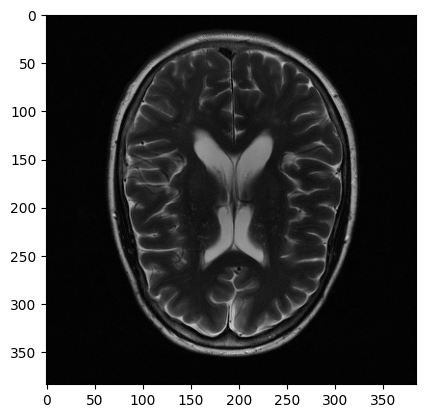

In [245]:
plt.imshow(image_labels[1], cmap='gray')

In [156]:
print(np.stack([img['image_input'][0], img['image_grappa'][0]]).shape)

(2, 384, 384)
